In [1]:
import pandas as pd
import qiime2 as q2
from biom import Table
import numpy as np
from scipy.stats import ttest_ind, spearmanr
from skbio.diversity.alpha import shannon
from qiime2.plugins.feature_table.methods import rarefy
from qiime2.plugins.feature_table.actions import filter_samples

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# take log-ratio
def lratio(df, n, d):
    lr_ = np.log(df.loc[n, :].sum(0)) - np.log(df.loc[d, :].sum(0))
    lr_[~np.isfinite(lr_)] = np.nan
    return  lr_.values
# ensure match (and no zero sum)
def match_subset(btdf_, mf_):
    shared_ = sorted(set(mf_.index) & set(btdf_.columns))
    mf_ = mf_.reindex(shared_)
    btdf_ = btdf_.reindex(shared_, axis=1)
    btdf_ = btdf_.T[btdf_.sum(0) > 0].T
    shared_ = sorted(set(mf_.index) & set(btdf_.columns))
    mf_ = mf_.reindex(shared_)
    btdf_ = btdf_.reindex(shared_, axis=1)
    btdf_ = btdf_[btdf_.sum(1) > 0]
    return btdf_, mf_


## Fecal microbiome

In [3]:
# import tables
table = q2.Artifact.import_data('FeatureTable[Frequency]',
                                '../data/AGP/fecal-gOTU-table.biom')
# import metdata
meta = q2.Metadata.load('../data/AGP/fecal-metadata.csv').to_dataframe()
meta = meta.replace({'Not provided':np.nan,
                     'unspecified':np.nan,
                     'other':np.nan,
                     'LabControl test':np.nan})
bt = table.view(Table)
btdf = pd.DataFrame(bt.matrix_data.toarray(),
                    bt.ids('observation'), bt.ids())
# import predictions
glco_loadings = pd.read_csv('../data/pathway-model/HS-completeness-capacity.csv', index_col=0)
table_save = glco_loadings[['taxa','CAZy.ID','pathway_capacity','pathway_completeness_abundance']].rename({'taxa':'species','CAZy.ID':'CAZy ID',
                                                                                              'pathway_capacity':'capacity',
                                                                                              'pathway_completeness_abundance':'completeness'})
table_save.to_csv('../results/tables/table-s3.csv')
# import taxonomy
tax_map = pd.read_csv('../data/wol-organism-tax.tsv',
                      sep='\t', index_col=0, header=None)
tax_map['sp'] = [' '.join(x.split(' ')[:2]) for x in tax_map[1]]
tax_map['genus'] = [x.split(' ')[0] for x in tax_map.sp]
tax_map = tax_map.reindex(sorted(set(tax_map.index) & set(btdf.index)))
# map
pathway_microbe_map = {target_:set(df[df.pathway_completeness_abundance == 1].taxa.dropna())
                       for target_, df in glco_loadings.groupby('Target')
                        if target_=='Heparan Sulfate'}
# match
btdf_sub, mf_sub = match_subset(btdf.copy(), meta.copy())

# take microbe ratios
for type_, spp_ in pathway_microbe_map.items():
    n_ = (tax_map[tax_map['sp'].isin(spp_)].index)  & set(btdf_sub.index)
    d_ = (set(tax_map.index) - set(n_)) & set(btdf_sub.index)
    mf_sub['log_ratio'] = lratio(btdf_sub, n_, d_)

# get rareified table and alpha diversity
table_rare = rarefy(table, 5000).rarefied_table
bt_rare = table_rare.view(Table)
btdf_rare = pd.DataFrame(bt_rare.matrix_data.toarray(),
                         bt_rare.ids('observation'), bt_rare.ids())
# shannon diveristy 
div_ = pd.DataFrame([shannon(btdf_rare.iloc[:,i].values)
                     for i in range(btdf_rare.shape[1])],
                    btdf_rare.columns, ['shannon_alpha']).reindex(mf_sub.index)
# add age grouping 
mf_sub = pd.concat([div_, mf_sub], axis=1)
label_ = ['0-5','5-10',
          '10-20','20-30',
          '30-40','40-50',
          '50-60', '60-70',
          '70-80+']
years_binned = pd.cut(x=mf_sub['age_years'],
                      bins=[0, 5, 10,
                            20, 30, 40,
                            50, 60, 
                            70, 80],
                      labels=label_)
mf_sub['age_years_decade'] = years_binned


/var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/ipykernel_74289/3394970075.py:34: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  n_ = (tax_map[tax_map['sp'].isin(spp_)].index)  & set(btdf_sub.index)
/Users/cmartino/miniconda3/envs/qiime2-2021.11/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


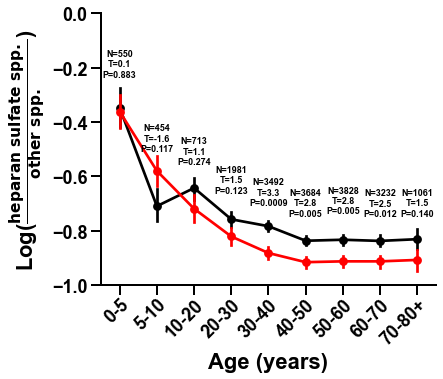

In [4]:

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

pal_ = {'Female':'black',
        'Male':'red'}

y_ = 'log_ratio'

fig, ax = plt.subplots(1, 1, figsize=(6,5), sharex=True)

sns.pointplot(y=y_,
              x='age_years_decade',
              hue='sex',
              palette=pal_,
              data=mf_sub,
              ci=68, ax=ax)


label_x = ('Log($\\frac{\mathrm{heparan\,\,sulfate\,\,spp.}}'
           '{\mathrm{other\,\,spp.}}$)')
ax.set_ylabel(label_x,
              fontsize=22,
              family = 'arial',
              weight='bold',
              color='black')
ax.set_xlabel('Age (years)',
              fontsize=22,
              family = 'arial',
              weight='bold',
              color='black')

ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=2, length=10)
ax.tick_params(axis='x', colors='black', width=2, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_color("black")
    tick.set_fontsize(18)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(18)
ax.set_ylim(-1,0)

# add a legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:], labels[:],
                    prop={'size':12}, loc=2, 
                    bbox_to_anchor=(.05, 1.0),
                    fancybox=True, framealpha=0.8,ncol=2
                    , markerscale=1.5, facecolor="white")
ax.legend_.remove()

max_ = []
for x_, k_ in enumerate(label_):
    df_ = mf_sub[mf_sub.age_years_decade == k_]
    t_, p_ = ttest_ind(df_[df_.sex == 'Female'][y_].dropna().values,
                       df_[df_.sex == 'Male'][y_].dropna().values)
    y, h, col = df_[y_].mean() - .03, .1, 'k'
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:3] + p_[p_.index('e'):]
        p_ = "N=%s\nT=%.1f\nP=%s" % (str(df_.shape[0]),t_,p_)
    elif p_ > .001:
        p_ = "N=%s\nT=%.1f\nP=%.3f" % (str(df_.shape[0]),t_,p_)
    elif p_ > .00001:
        p_ = "N=%s\nT=%.1f\nP=%.4f" % (str(df_.shape[0]),t_,p_)
    max_.append(y+h)
    ax.text(x_, y+h+.05, p_, weight='bold',
            ha='center', va='bottom',
            family = 'arial',
            color=col, fontsize=9)
    
    

plt.savefig('../results/figures/Fig2C.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()


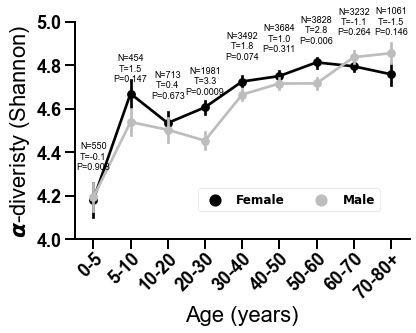

In [5]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

pal_ = {'Female':'#000000',
        'Male':'#bdbdbd'}

y_ = 'shannon_alpha'

fig, ax = plt.subplots(1, 1, figsize=(6,4), sharex=True)

sns.pointplot(y=y_,
              x='age_years_decade',
              hue='sex',
              palette=pal_,
              data=mf_sub,
              ci=68, ax=ax)


label_x = ('$\\alpha$-diveristy (Shannon)')
ax.set_ylabel(label_x,
              fontsize=22,
              family = 'arial',
              weight='normal',
              color='black')
ax.set_xlabel('Age (years)',
              fontsize=22,
              family = 'arial',
              weight='normal',
              color='black')

ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=2, length=10)
ax.tick_params(axis='x', colors='black', width=2, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_color("black")
    tick.set_fontsize(18)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(18)
ax.set_ylim(4,5)

# add a legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:], labels[:],
                    prop={'size':12}, loc=2, 
                    bbox_to_anchor=(.35, .26),
                    fancybox=True, framealpha=0.8,ncol=2
                    , markerscale=1.5, facecolor="white")

max_ = []
for x_, k_ in enumerate(label_):
    df_ = mf_sub[mf_sub.age_years_decade == k_]
    t_, p_ = ttest_ind(df_[df_.sex == 'Female'][y_].dropna().values,
                       df_[df_.sex == 'Male'][y_].dropna().values)
    y, h, col = df_[y_].mean() - .03, .1, 'k'
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:3] + p_[p_.index('e'):]
        p_ = "N=%s\nT=%.1f\nP=%s" % (str(df_.shape[0]),t_,p_)
    elif p_ > .001:
        p_ = "N=%s\nT=%.1f\nP=%.3f" % (str(df_.shape[0]),t_,p_)
    elif p_ > .00001:
        p_ = "N=%s\nT=%.1f\nP=%.4f" % (str(df_.shape[0]),t_,p_)
    max_.append(y+h)
    ax.text(x_, y+h+.05, p_, weight='normal',
            ha='center', va='bottom',
            family = 'arial', 
            color=col, fontsize=9)

plt.savefig('../results/figures/FigS1B.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

In [6]:
from scipy.stats import pearsonr

corr_res = {}
for k_, df_ in mf_sub.dropna(subset=['shannon_alpha',
                                       'log_ratio']).groupby('sex'):
    corr_res[('AGP',k_)] = pearsonr(df_['shannon_alpha'].values,
                            df_['log_ratio'].values)

resdf = pd.DataFrame(corr_res, ['R', 'p-value'])
#resdf.to_csv('../results/tables/table-s2-agp.csv')
resdf


AGP          
               Female      Male
R       -1.800123e-01  0.000098
p-value  2.239831e-57  0.993635

## Saliva Microbiome


In [7]:
# import table
table = q2.Artifact.import_data('FeatureTable[Frequency]',
                                '../data/AGP/saliva-gOTU-table.biom')
bt = table.view(Table)
btdf = pd.DataFrame(bt.matrix_data.toarray(), bt.ids('observation'), bt.ids())
# import metadata
meta = q2.Metadata.load('../data/AGP/saliva-metadata.csv').to_dataframe()
meta = meta.replace({'Not provided':np.nan,
                     'unspecified':np.nan,
                     'other':np.nan,
                     'LabControl test':np.nan})
# import predictions
glco_loadings = pd.read_csv('../data/pathway-model/HS-completeness-capacity.csv', index_col=0)
# import taxonomy
tax_map = pd.read_csv('../data/wol-organism-tax.tsv',
                      sep='\t', index_col=0, header=None)
tax_map = tax_map.reindex(sorted(set(tax_map.index) & set(btdf.index)))
tax_map['sp'] = [' '.join(x.split(' ')[:2]) for x in tax_map[1]]
tax_map['genus'] = [x.split(' ')[0] for x in tax_map.sp]
# map
pathway_microbe_map = {target_:set(df[df.pathway_completeness_abundance == 1].taxa.dropna())
                       for target_, df in glco_loadings.groupby('Target')}
# match
btdf_sub, mf_sub = match_subset(btdf.copy(), meta.copy())
# take microbe ratios
for type_, spp_ in pathway_microbe_map.items():
    n_ = (tax_map[tax_map['sp'].isin(spp_)].index)  & set(btdf_sub.index)
    d_ = (set(tax_map.index) - set(tax_map[tax_map['sp'].isin(spp_)].index)) & set(btdf_sub.index)
    mf_sub['log_ratio'] = lratio(btdf_sub, n_, d_)
# bin ages
label_ = ['0-10','10-20','20-30',
          '30-40','40-50',
          '50-60', '60-70+']
years_binned = pd.cut(x=mf_sub['age_years'],
                      bins=[0, 10,20, 30,
                            40, 50, 60, 70],
                      labels=label_)
mf_sub['age_years_decade'] = years_binned



/var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/ipykernel_74289/1841912781.py:27: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  n_ = (tax_map[tax_map['sp'].isin(spp_)].index)  & set(btdf_sub.index)


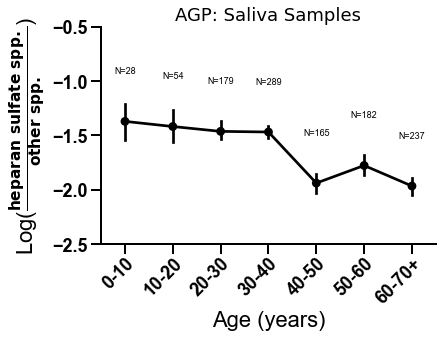

In [8]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'


pal_ = {'Female':'#000000',
        'Male':'#bdbdbd'}

y_ = 'log_ratio'

fig, ax = plt.subplots(1, 1, figsize=(6,4), sharex=True)

sns.pointplot(y=y_,
              x='age_years_decade',
              color='black',
              #hue='sex',
              #palette=pal_,
              data=mf_sub,
              ci=68, ax=ax)


label_x = ('Log($\\frac{\mathrm{heparan\,\,sulfate\,\,spp.}}'
           '{\mathrm{other\,\,spp.}}$)')
ax.set_ylabel(label_x,
              fontsize=22,
              family = 'arial',
              weight='normal',
              color='black')
ax.set_xlabel('Age (years)',
              fontsize=22,
              family = 'arial',
              weight='normal',
              color='black')

ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=2, length=10)
ax.tick_params(axis='x', colors='black', width=2, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_color("black")
    tick.set_fontsize(18)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(18)
ax.set_ylim(-2.5,-0.5)

# add a legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:], labels[:],
                    prop={'size':12}, loc=2, 
                    bbox_to_anchor=(.05, .20),
                    fancybox=True, framealpha=0.8,ncol=2
                    , markerscale=1.5, facecolor="white")

max_ = []
for x_, k_ in enumerate(label_):
    df_ = mf_sub[mf_sub.age_years_decade == k_]
    y, h, col = df_[y_].mean() - .03, .1, 'k'
    annot_ = "N=%s" % (str(df_.shape[0]))
    max_.append(y+h)
    ax.text(x_, y+h+.35, annot_, weight='normal',
            ha='center', va='bottom',
            family = 'arial', 
            color=col, fontsize=9)
ax.set_title('AGP: Saliva Samples',
             color='black',
             weight='normal',
             fontsize=18)
ax.legend_.remove()

    
plt.savefig('../results/figures/FigS5.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()